# Identifying fraud from Enron e-mails

## Table of Contents
* <a href="#sec1">1. Introduction</a>
  * <a href="#sec1.1"> 1.1. Initial statements </a>

* <a href="#sec2">2. Data Wrangling</a>
  * <a href="#sec2.1"> 2.1. Loading the data </a>
  * <a href="#sec2.2"> 2.2. Analyzing string data </a>
  * <a href="#sec2.3"> 2.3. Converting string "NaN" to numpy.NaN </a>
  * <a href="#sec2.4"> 2.4. Counting valid data </a>
  * <a href="#sec2.5"> 2.5. Outlier removal </a>
  * <a href="#sec2.6"> 2.6. Checking the class distribution </a>
  * <a href="#sec2.7"> 2.7. Stratified data split </a>

* <a href="#sec3">3. Feature selection</a>
  * <a href="#sec3.1"> 3.1. Verifying correlation among variables </a>
  * <a href="#sec3.2"> 3.2. Applying PCA on correlated features to generate a new one </a>
  * <a href="#sec3.3"> 3.3. Univariate feature selection </a>
  * <a href="#sec3.4"> 3.4. Alternative feature selection </a>
  * <a href="#sec3.5"> 3.5. Feature scaling </a>
  
* <a href="#sec4">4. Machine Learning</a>
  * <a href="#sec4.1"> 4.1. Naive Bayes classifier </a>
  * <a href="#sec4.2"> 4.2. AdaBoost classifier </a>
  * <a href="#sec4.3"> 4.3. SVM classifier </a>
  * <a href="#sec4.4"> 4.4. Conclusions</a>

<a id='sec1'></a>
## 1. Introduction
This project is part of the Udacity Data Analyst Nanodegree and refers to Intro to Machine Learning module. Its main scope is to build a person of interest (POI) identifier based on financial and email data made public as a result of the Enron scandal, as explained below.

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives

<a id='sec1.1'></a>
### 1.1. Initial statements
This section sets up import statements for all the packages that will be used throughout this python notebook.

In [77]:
# essnential imports
import pickle   # pkl file 
import os       # Directory 
import sys      # Subrputines
import email    # Email content separater

# Data wrangling
import pandas as pd
import numpy as np

# Analysis
import networkx as nx    # Network 
from nltk.tokenize.regexp import RegexpTokenizer   # NLP
import wordcloud    # Word of interest

# Visualization packages:
import seaborn as sns; sns.set_style('whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## Forcing pandas to display any number of elements
## Atleast 2000 without having value
pd.set_option('display.max_columns', None)   # None
pd.options.display.max_seq_items = 2000      # 2000

<a id='sec2'></a>
## 2. Data wrangling
Analyzing the data integrity, the expected values and removing outliers.

<a id='sec2.1'></a>
### 2.1. Loading the data

In [3]:
records = pd.DataFrame.from_dict(
    pd.read_pickle("final_project/final_project_dataset.pkl"),
    orient='index')
emails = pd.read_csv('emails.csv')

In [4]:
## What is the data type and length?

### record dataset
print("Emails Dateset:\n")
print('record dataset type: ',type(records))
print('record dataset length: ',len(records))
print('record dataset shape', records.shape)
print("\n")

### emails dataset
print("Emails Dateset:\n")
print('emails dataset type: ',type(emails))
print('emails dataset length: ',len(emails))
print('emails dataset shape', emails.shape)


Emails Dateset:

record dataset type:  <class 'pandas.core.frame.DataFrame'>
record dataset length:  146
record dataset shape (146, 21)


Emails Dateset:

emails dataset type:  <class 'pandas.core.frame.DataFrame'>
emails dataset length:  517401
emails dataset shape (517401, 2)


In [5]:
## Exploring the dataset through pandas.Dataframe
records.head()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
METTS MARK,365788,807,NaN,1061827,NaN,600000,mark.metts@enron.com,NaN,NaN,585062,94299,38,NaN,29,1740,1,False,NaN,702,585062,NaN
BAXTER JOHN C,267102,NaN,1295738,5634343,NaN,1200000,NaN,NaN,-1386055,10623258,11200,NaN,6680544,NaN,2660303,NaN,False,1586055,NaN,3942714,NaN
ELLIOTT STEVEN,170941,NaN,NaN,211725,NaN,350000,steven.elliott@enron.com,NaN,-400729,6678735,78552,NaN,4890344,NaN,12961,NaN,False,NaN,NaN,1788391,NaN
CORDES WILLIAM R,NaN,764,NaN,NaN,NaN,NaN,bill.cordes@enron.com,NaN,NaN,1038185,NaN,10,651850,12,NaN,0,False,NaN,58,386335,NaN
HANNON KEVIN P,243293,1045,NaN,288682,NaN,1500000,kevin.hannon@enron.com,NaN,-3117011,6391065,34039,32,5538001,32,11350,21,True,1617011,1035,853064,NaN


In [6]:
## Exploring the dataset through pandas.Dataframe
emails.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


We look in datail email dataset by extracting more information from it

In [7]:
# Parse the emails into a list email objects
# [<email.message.Message at 0x7fc713fd8690>,...]
messages = list(map(email.message_from_string, emails['message']))

# Drop "message" column in deep
emails.drop('message', axis=1, inplace=True)

# Get fields from parsed email objects
# ['Message-ID', 'Date', 'From', 'To', 'Subject',
#  'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding',
#  'X-From', 'X-To','X-cc', 'X-bcc', 'X-Folder', 'X-Origin',
#  'X-FileName']
keys = messages[0].keys()
for key in keys:
    emails[key] = [doc[key] for doc in messages]

# Parse content from emails
def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)    
    
    
emails['content'] = list(map(get_text_from_email, messages))

# Split multiple email addresses
def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

emails['From'] = emails['From'].map(split_email_addresses)
emails['To'] = emails['To'].map(split_email_addresses)

# # Extract the root of 'file' as 'user'
emails['user'] = emails['file'].map(lambda x:x.split('/')[0])
del messages

emails.head()

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p
1,allen-p/_sent_mail/10.,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p
2,allen-p/_sent_mail/100.,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p
3,allen-p/_sent_mail/1000.,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",(phillip.allen@enron.com),(randall.gay@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p
4,allen-p/_sent_mail/1001.,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p


<a id='sec2.2'></a>
### 2.2 Analyzing string data:

In [8]:
records.describe()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
count,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146
unique,95,87,40,126,5,42,112,19,45,125,95,58,102,65,93,42,2,53,84,98,18
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
freq,51,60,107,21,142,64,35,128,97,20,51,60,44,60,53,60,128,80,60,36,129


In [9]:
emails.describe()

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
count,517401,517401,517401,517401,495554,517401,517372,517372,517372,517372,517372,517372,517372,517372,517372,517372,517401,517401
unique,517401,517401,224128,20328,54748,159290,1,2,3,27980,73552,33701,132,5335,259,429,249025,150
top,horton-s/_sent_mail/60.,<10831736.1075841720548.JavaMail.evans@thyme>,"Wed, 27 Jun 2001 16:02:00 -0700 (PDT)",(kay.mann@enron.com),(pete.davis@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Kay Mann,,,,\Kay_Mann_June2001_1\Notes Folders\All documents,Kaminski-V,vkamins.nsf,"As you know, Enron Net Works (ENW) and Enron G...",kaminski-v
freq,1,1,1118,16735,9155,19187,517372,479286,494971,16324,9124,388486,517197,6639,26995,24029,112,28465


In [10]:
## Printing out the features that must be checked (string types are not iterable!

def listing_features(dataset):
    return [col for col in dataset.columns if (type(dataset[col][0]) is str)]

features_to_check_from_record = listing_features(records)
features_to_check_from_emails = listing_features(emails)

In [11]:
features_to_check_from_record 

['deferral_payments',
 'loan_advances',
 'email_address',
 'restricted_stock_deferred',
 'deferred_income',
 'exercised_stock_options',
 'long_term_incentive',
 'director_fees']

In [12]:
features_to_check_from_emails

['file',
 'Message-ID',
 'Date',
 'Subject',
 'Mime-Version',
 'Content-Type',
 'Content-Transfer-Encoding',
 'X-From',
 'X-To',
 'X-cc',
 'X-bcc',
 'X-Folder',
 'X-Origin',
 'X-FileName',
 'content',
 'user']

From the features above, only *email_address* is expected to contain string type data. In this way, an in-depth look must be done in the other ones.

<a id='sec2.3'></a>
### 2.3 Converting string "NaN" to numpy.NaN
From the previous output, it was clear there are some 'NaN' in string type instead of numerical or numpy type, which causes some troubles when plotting data or using some classifier. Due to this, the next step is to scan the dataset for 'NaN' string and replace it by numpy.NaN.

In [13]:
# for column in dataset.columns:
#     dataset[column] = dataset[column].apply(lambda x: np.NaN if x == 'NaN' else x)
    
def str_nan_into_np_nan(dataset):
    for column in dataset.columns:
        dataset[column] = dataset[column].apply(
            lambda x: np.NaN if x == 'NaN' else x
        )
       
str_nan_into_np_nan(records)
str_nan_into_np_nan(emails)

In [14]:
## Checking the dataset information:
records.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, METTS MARK to GLISAN JR BEN F
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   salary                     95 non-null     float64
 1   to_messages                86 non-null     float64
 2   deferral_payments          39 non-null     float64
 3   total_payments             125 non-null    float64
 4   loan_advances              4 non-null      float64
 5   bonus                      82 non-null     float64
 6   email_address              111 non-null    object 
 7   restricted_stock_deferred  18 non-null     float64
 8   deferred_income            49 non-null     float64
 9   total_stock_value          126 non-null    float64
 10  expenses                   95 non-null     float64
 11  from_poi_to_this_person    86 non-null     float64
 12  exercised_stock_options    102 non-null    float64
 13  from_messages              86 non-

In [15]:
emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   file                       517401 non-null  object
 1   Message-ID                 517401 non-null  object
 2   Date                       517401 non-null  object
 3   From                       517401 non-null  object
 4   To                         495554 non-null  object
 5   Subject                    517401 non-null  object
 6   Mime-Version               517372 non-null  object
 7   Content-Type               517372 non-null  object
 8   Content-Transfer-Encoding  517372 non-null  object
 9   X-From                     517372 non-null  object
 10  X-To                       517372 non-null  object
 11  X-cc                       517372 non-null  object
 12  X-bcc                      517372 non-null  object
 13  X-Folder                   517372 non-null  

<a id='sec2.4'></a>
### 2.4 Counting valid data
As seen before, there are many null data in our dataset. In order to select the most appropriate features to explore

In [16]:
def count_valid_data(dataset):
    return dataset.dropna()

not_mull_records = count_valid_data(records)
not_mull_emails = count_valid_data(emails)

In [17]:
not_mull_records.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   salary                     0 non-null      float64
 1   to_messages                0 non-null      float64
 2   deferral_payments          0 non-null      float64
 3   total_payments             0 non-null      float64
 4   loan_advances              0 non-null      float64
 5   bonus                      0 non-null      float64
 6   email_address              0 non-null      object 
 7   restricted_stock_deferred  0 non-null      float64
 8   deferred_income            0 non-null      float64
 9   total_stock_value          0 non-null      float64
 10  expenses                   0 non-null      float64
 11  from_poi_to_this_person    0 non-null      float64
 12  exercised_stock_options    0 non-null      float64
 13  from_messages              0 non-null      float64
 14  other      

In [18]:
not_mull_emails.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495547 entries, 0 to 517400
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   file                       495547 non-null  object
 1   Message-ID                 495547 non-null  object
 2   Date                       495547 non-null  object
 3   From                       495547 non-null  object
 4   To                         495547 non-null  object
 5   Subject                    495547 non-null  object
 6   Mime-Version               495547 non-null  object
 7   Content-Type               495547 non-null  object
 8   Content-Transfer-Encoding  495547 non-null  object
 9   X-From                     495547 non-null  object
 10  X-To                       495547 non-null  object
 11  X-cc                       495547 non-null  object
 12  X-bcc                      495547 non-null  object
 13  X-Folder                   495547 non-null  

From the output above, the features named *deferral_payments; restricted_stock_deferred;* and *director_fees* are removed. Doing so the pre-selected features list can be defined accordingly to its context:

In [19]:
## Only numerical features are being considered here from records
financialFeatures = ['salary','bonus', 'exercised_stock_options', 'restricted_stock', 'shared_receipt_with_poi',
                     'total_payments', 'expenses', 'total_stock_value', 'deferred_income', 'long_term_incentive']
behavioralFeatures = ['to_messages', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'other']
allFeatures = ['poi','salary','bonus', 'exercised_stock_options', 'restricted_stock', 'shared_receipt_with_poi',
               'total_payments', 'expenses', 'total_stock_value', 'deferred_income', 'long_term_incentive',
               'to_messages', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'other']

Since in the *feature_format()* method the "NaN" strings are replaced by zeros, we need to make this adjustment here.

In [20]:
records.fillna(0,inplace=True)
# emails.fillna(0,inplace=True)

<a id='sec2.5'></a>
### 2.5 Outlier removal
In this section we look for identifying and, if it is the case, removing outliers in our dataset.

<a id='sec2.5.1'></a>
### 2.5.1 Visualizing data by features
The objective here is to visualize how the data is distributed accordingly to each feature, as well as identifying outliers through visual inspection. For this we make use of a function build based on the code available in (http://stamfordresearch.com/outlier-removal-in-python-using-iqr-rule/)

In [21]:
def visualizeFeat(series, figsize):
    ''' series = pandas.series, which can be inputed as "dataframe['feature']
        figsize = (width,length)'''
    fig, axes = plt.subplots(2,1,figsize=figsize, sharex=True)
    series.plot(kind='kde', ax=axes[0])
    sns.boxplot(x=series, ax=axes[1])
    plt.xlim(series.min(), series.max()*1.1)
    return

The function above seems useful to get information for only one variable. Since we want to explore the whole dataset (or at least a good chunk of it), we will code a function to show them all:

In [22]:
def visualize3Feats(dataset, features):
    '''Shows the distribution and the boxplot for the given features of a pandas.Dataframe:
        dataset = pandas dataframe.
        features = list of features of interest'''
    ## Building the Figure:
    fig, axes = plt.subplots(2,3,figsize=(15,6), sharex=False)
    for col, feat in enumerate(features):
        dataset[feat].plot(kind='kde', ax=axes[0,col])
        sns.boxplot(x=dataset[feat], ax=axes[1,col])
        axes[0,col].set_xlim(dataset[feat].min(), dataset[feat].max()*1.1);
        axes[1,col].set_xlim(dataset[feat].min(), dataset[feat].max()*1.1);
    return

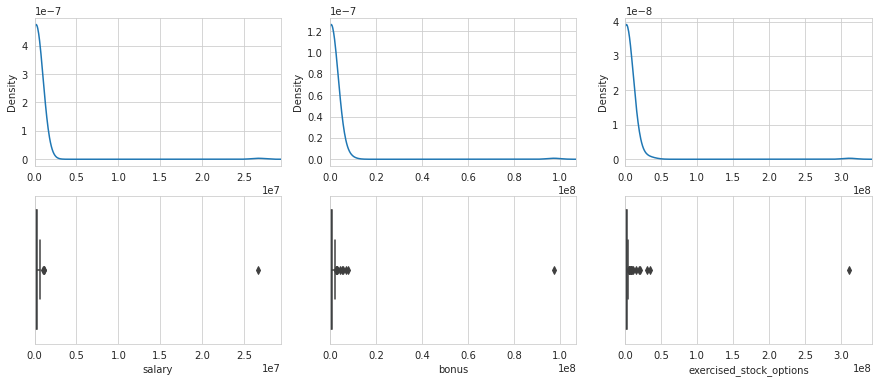

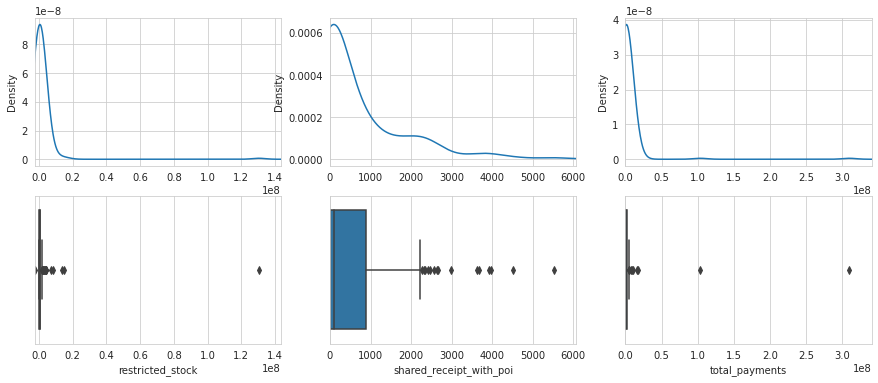

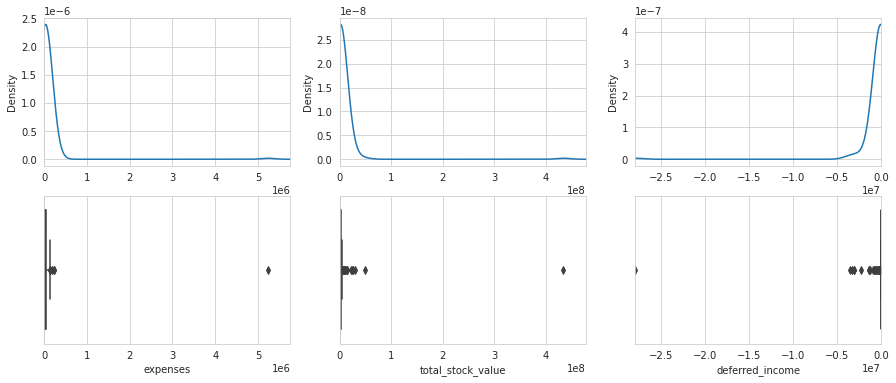

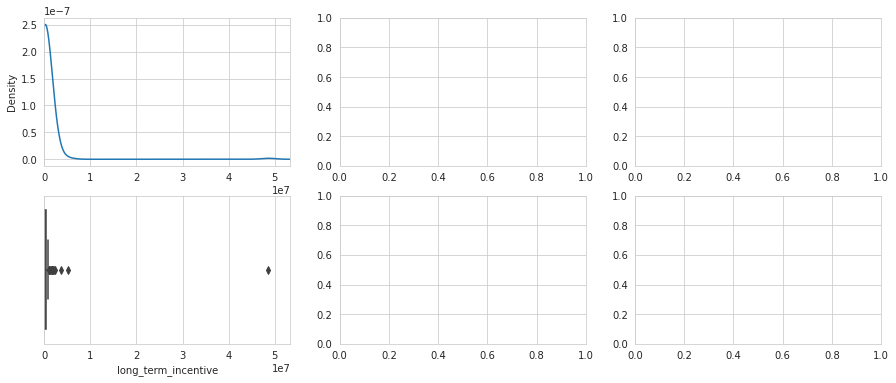

In [23]:
### Visualizing financial features:
numPlots = int(np.ceil(len(financialFeatures)/3.))
for i in range(numPlots):
    shift = i*3
    visualize3Feats(records,financialFeatures[0+shift:3+shift])

From the charts above, it becomes evident there is at least one strong outlier sample (which in fact was identified during the lesson as the TOTAL instance). Even after removing it (see Section 2.4.2) there are still remaining outliers. However, since they are probably related to what we are looking for, they won't be removed.

In [24]:
emails['Date'] = pd.to_datetime(emails['Date'], errors='coerce', utc=True)

Text(0, 0.5, 'N emails')

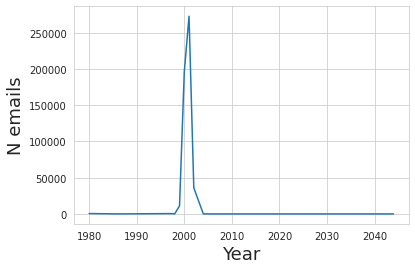

In [25]:
# Most emails send by year 
ax = emails.groupby(emails['Date'].dt.year)['content'].count().plot()
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('N emails', fontsize=18)

Text(0, 0.5, 'N emails')

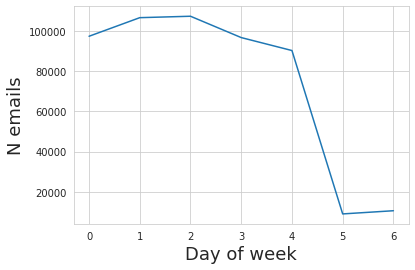

In [26]:
# Most emails send by week
ax = emails.groupby(emails['Date'].dt.dayofweek)['content'].count().plot()
ax.set_xlabel('Day of week', fontsize=18)
ax.set_ylabel('N emails', fontsize=18)

Text(0, 0.5, 'N emails')

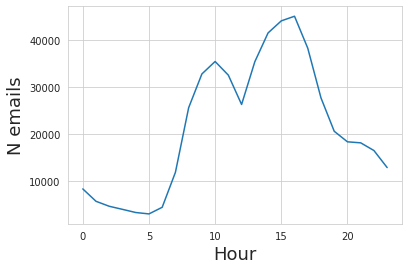

In [27]:
# Most emails send by hours
ax = emails.groupby(emails['Date'].dt.hour)['content'].count().plot()
ax.set_xlabel('Hour', fontsize=18)
ax.set_ylabel('N emails', fontsize=18)

## Most words used in emails

In [28]:
# Count words in Subjects and content
tokenizer = RegexpTokenizer(r'(?u)\b\w\w+\b')
emails['subject_wc'] = emails['Subject'].map(lambda x: len(tokenizer.tokenize(x)))
emails['content_wc'] = emails['content'].map(lambda x: len(tokenizer.tokenize(x)))

In [29]:
grouped_by_people = emails.groupby('user').agg({
        'content': 'count', 
        'subject_wc': 'mean',
        'content_wc': 'mean',
    })
grouped_by_people.rename(columns={'content': 'N emails', 
                                  'subject_wc': 'Subject word count', 
                                  'content_wc': 'Content word count'}, inplace=True)
grouped_by_people.sort_values('N emails', ascending=False).head()

,N emails,Subject word count,Content word count
user,,,
kaminski-v,28465,4.217530,255.906025
dasovich-j,28234,5.237373,603.393391
kean-s,25351,4.959331,490.837561
mann-k,23381,4.211796,207.195501
jones-t,19950,4.748221,185.462607


Social network analyses of email senders and recipients
Let's see who sends the most emails to whom

First we'll only look at emails sent to single email address, which may be more important personal communications

In [30]:
sub_df = emails[['From', 'To', 'Date']].dropna()
print(sub_df.shape)
# drop emails sending to multiple addresses
sub_df = sub_df.loc[sub_df['To'].map(len) == 1]
print(sub_df.shape)

(495554, 3)
(354600, 3)


In [31]:
sub_df = sub_df.groupby(['From', 'To']).count().reset_index()
# Unpack frozensets
sub_df['From'] = sub_df['From'].map(lambda x: next(iter(x)))
sub_df['To'] = sub_df['To'].map(lambda x: next(iter(x)))
# rename column
sub_df.rename(columns={'Date': 'count'}, inplace=True)
sub_df.sort_values('count', ascending=False).head(10)

,From,To,count
17908,pete.davis@enron.com,pete.davis@enron.com,9141
38033,vince.kaminski@enron.com,vkaminski@aol.com,4308
28920,enron.announcements@enron.com,all.worldwide@enron.com,2206
28935,enron.announcements@enron.com,all.houston@enron.com,1701
26510,kay.mann@enron.com,suzanne.adams@enron.com,1528
38031,vince.kaminski@enron.com,shirley.crenshaw@enron.com,1190
14564,steven.kean@enron.com,maureen.mcvicker@enron.com,1014
26309,kay.mann@enron.com,nmann@erac.com,980
18926,kate.symes@enron.com,evelyn.metoyer@enron.com,915
18930,kate.symes@enron.com,kerri.thompson@enron.com,859


Apparently some people send a lot of emails to themselves. It maybe very interesting to look at the differences between emails sent to selves and to others.

In [32]:
# Make a network of email sender and receipients
G = nx.from_pandas_edgelist(sub_df, 'From', 'To', edge_attr='count', create_using=nx.DiGraph())
print('Number of nodes: %d, Number of edges: %d' % (G.number_of_nodes(), G.number_of_edges()))

Number of nodes: 25396, Number of edges: 56144


What do the emails say?
In the subjects:

In [33]:
emails.head(0)

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user,subject_wc,content_wc


In [34]:
ENGLISH_STOP_WORDS = ['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'ain', 'all',
                      'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among',
                      'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone',
                      'anything', 'anyway', 'anywhere', 'are', 'aren', 'around', 'as', 'at', 'back', 'be',
                      'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand',
                      'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'bill', 'both', 
                      'bottom', 'but', 'by', 'call', 'can', 'cannot', 'cant', 'co', 'con', 'could', 'couldn',
                      'couldnt', 'cry', 'd', 'de', 'describe', 'detail', 'did', 'didn', 'do', 'does', 'doesn',
                      'doing', 'don', 'done', 'down', 'due', 'during', 'each', 'eg', 'eight', 'either', 
                      'eleven', 'else', 'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever', 'every', 
                      'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'fify', 'fill', 
                      'find', 'fire', 'first', 'five', 'for', 'former', 'formerly', 'forty', 'found', 'four', 
                      'from', 'front', 'full', 'further', 'get', 'give', 'go', 'had', 'hadn', 'has', 'hasn', 
                      'hasnt', 'have', 'haven', 'having', 'he', 'hence', 'her', 'here', 'hereafter', 'hereby', 
                      'herein', 'hereupon', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'however', 
                      'hundred', 'i', 'ie', 'if', 'in', 'inc', 'indeed', 'interest', 'into', 'is', 'isn', 'it',
                      'its', 'itself', 'just', 'keep', 'last', 'latter', 'latterly', 'least', 'less', 'll', 
                      'ltd', 'm', 'ma', 'made', 'many', 'may', 'me', 'meanwhile', 'might', 'mightn', 'mill', 
                      'mine', 'more', 'moreover', 'most', 'mostly', 'move', 'much', 'must', 'mustn', 'my', 
                      'myself', 'name', 'namely', 'needn', 'neither', 'never', 'nevertheless', 'next', 'nine', 
                      'no', 'nobody', 'none', 'noone', 'nor', 'not', 'nothing', 'now', 'nowhere', 'o', 'of', 
                      'off', 'often', 'on', 'once', 'one', 'only', 'onto', 'or', 'other', 'others', 'otherwise',
                      'our', 'ours', 'ourselves', 'out', 'over', 'own', 'part', 'per', 'perhaps', 'please', 
                      'put', 'rather', 're', 's', 'same', 'see', 'seem', 'seemed', 'seeming', 'seems', 'serious', 
                      'several', 'shan', 'she', 'should', 'shouldn', 'show', 'side', 'since', 'sincere', 'six',
                      'sixty', 'so', 'some', 'somehow', 'someone', 'something', 'sometime', 'sometimes',
                      'somewhere', 'still', 'such', 'system', 't', 'take', 'ten', 'than', 'that', 'the', 'their', 
                      'theirs', 'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 
                      'therefore', 'therein', 'thereupon', 'these', 'they', 'thick', 'thin', 'third', 'this',
                      'those', 'though', 'three', 'through', 'throughout', 'thru', 'thus', 'to', 'together', 
                      'too', 'top', 'toward', 'towards', 'twelve', 'twenty', 'two', 'un', 'under', 'until', 
                      'up', 'upon', 'us', 've', 'very', 'via', 'was', 'wasn', 'we', 'well', 'were', 'weren', 
                      'what', 'whatever', 'when', 'whence', 'whenever', 'where', 'whereafter', 'whereas', 
                      'whereby', 'wherein', 'whereupon', 'wherever', 'whether', 'which', 'while', 'whither', 
                      'who', 'whoever', 'whole', 'whom', 'whose', 'why', 'will', 'with', 'within', 'without', 
                      'won', 'would', 'wouldn', 'y', 'yet', 'you', 'your', 'yours', 'yourself', 'yourselves']

# print(ENGLISH_STOP_WORDS)

(-0.5, 799.5, 599.5, -0.5)

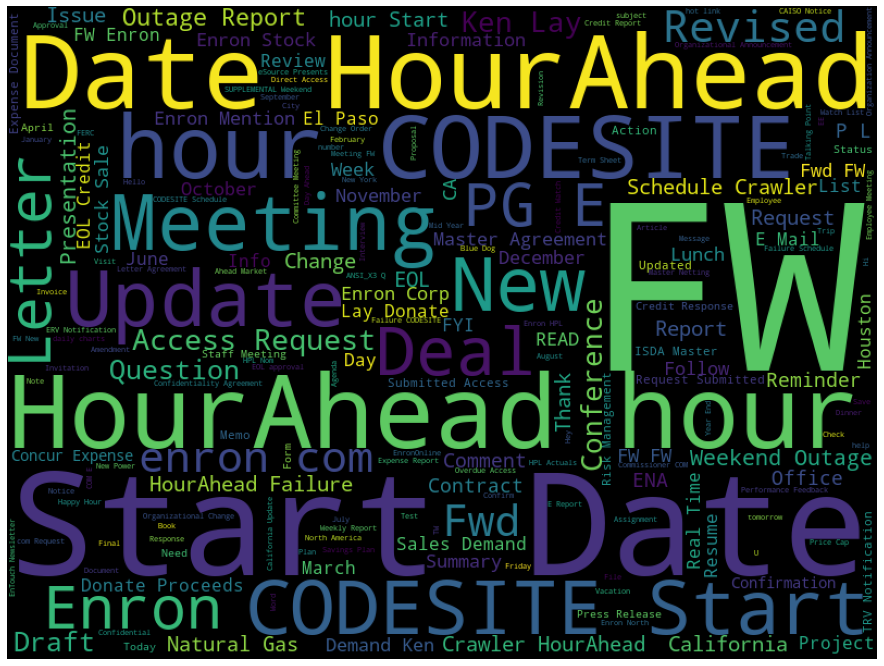

In [35]:
subjects = ' '.join(emails['Subject'])
fig, ax = plt.subplots(figsize=(16, 12))
wc = wordcloud.WordCloud(width=800, 
                         height=600, 
                         max_words=200,
                         stopwords=ENGLISH_STOP_WORDS).generate(subjects)
ax.imshow(wc)
ax.axis("off")

(-0.5, 799.5, 599.5, -0.5)

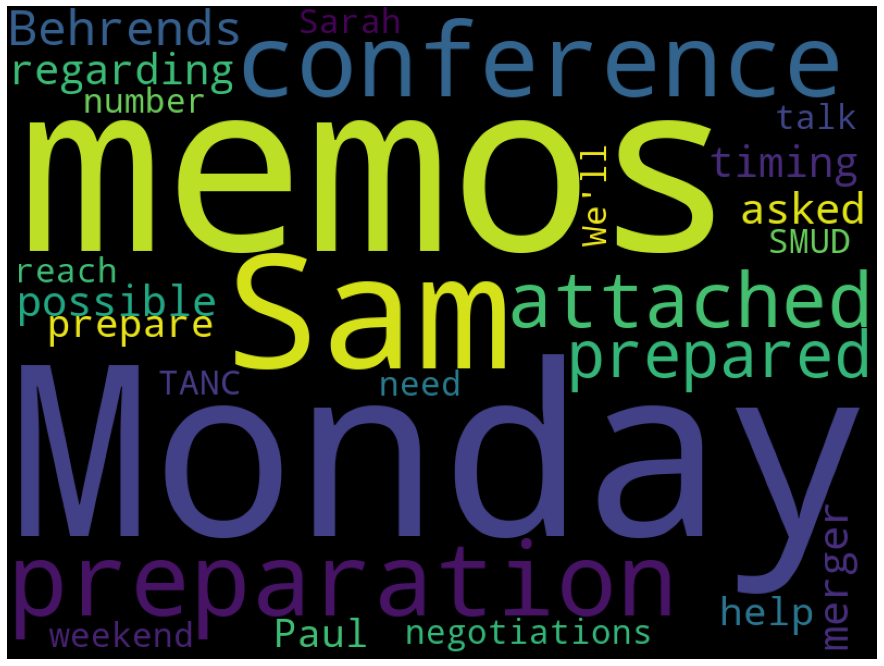

In [36]:
contents = ' '.join(emails.sample()['content'])
fig, ax = plt.subplots(figsize=(16, 12))
wc = wordcloud.WordCloud(width=800, 
                         height=600, 
                         max_words=200,
                         stopwords=ENGLISH_STOP_WORDS).generate(contents)
ax.imshow(wc)
ax.axis("off")

[(28465, 'kaminski-v'), (28234, 'dasovich-j'), (25351, 'kean-s'), (23381, 'mann-k'), (19950, 'jones-t'), (18687, 'shackleton-s'), (13875, 'taylor-m'), (13032, 'farmer-d'), (12436, 'germany-c'), (11830, 'beck-s'), (10827, 'symes-k'), (10655, 'nemec-g'), (8022, 'scott-s'), (8009, 'rogers-b'), (7823, 'bass-e'), (7329, 'sanders-r'), (6490, 'campbell-l'), (6071, 'shapiro-r'), (6054, 'guzman-m'), (5937, 'lay-k')]


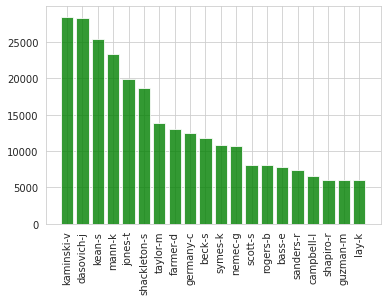

'The histogram shows users vs no. of emails they sent'

In [37]:
# Creating from_user list
userList = []
userList = emails['user'].unique()

# Number of emails sent by each users
count = []
counter = 0 
for l in userList:
    for user in emails['user']:
        if user == l:
            counter += 1
    count.append(counter)
    counter = 0


'''Let us take a look at how many email were sent by each user. 
This plot may indicate erratic email usage. 
We plot top 20 users who sent the highest number of emails.'''

new_list = sorted(list(zip(count, userList)), reverse = True)[:20] ##merge both lists and sort top 20, 
print(new_list)
num, mailer = zip(*new_list) ## separate lists previously merged and use them for plotting
mail = range(len(new_list))
plt.bar(mail, num, align = 'center', color ='green', alpha=0.8)
plt.xticks(mail, mailer, rotation='vertical')
plt.show()

'''The histogram shows users vs no. of emails they sent'''

<a id='sec2.5.2'></a>
### 2.5.2 Removing **TOTAL** instance
As observed before, the "TOTAL" instance must be removed, since we are interested only on POIs.

In [38]:
records.drop('TOTAL',inplace=True)  #Removing the anomalous instance

<a id='sec2.6'></a>
### 2.6 Checking the class distribution

In [39]:
## Counting gender classes
dataset = records
dataset['poi'].value_counts()
# records

False    127
True      18
Name: poi, dtype: int64

<a id='sec2.7'></a>
### 2.7 Stratified data split
Besides we can extract features from the whole dataset, when we are training machine learning algorithms is really important to split the data into training and testing subsets, in order to avoid overfitting. But as seen above, our data is unbalanced and so it is important to split data in a stratified way, i.e., each subset must have the same proportion of each class.

In [40]:
from sklearn.model_selection import train_test_split
# import sklearn

In [41]:
## For pandas.Dataframe the train_test_split is given in a straight way:
trainData, testData = train_test_split(dataset, test_size=0.3, random_state=42, stratify=dataset['poi'])

In [42]:
## Converting boolean data into int:
dataset['poi'] = dataset['poi'].apply(lambda x: int(x))
trainData['poi'] = trainData['poi'].apply(lambda x: int(x))
testData['poi'] = testData['poi'].apply(lambda x: int(x))

/home/hamza/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/hamza/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


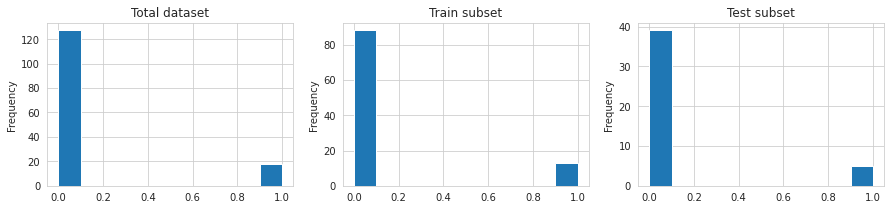

In [43]:
## Evaluating the class distribution:
fig2, axes2 = plt.subplots(1,3,figsize=(15,3), sharex=False);
dataset['poi'].plot(kind='hist', ax=axes2[0], title='Total dataset');
trainData['poi'].plot(kind='hist', ax=axes2[1], title='Train subset');
testData['poi'].plot(kind='hist', ax=axes2[2], title='Test subset');

<a id='sec3'></a>
## 3. Feature extraction
**Note:** the initial approach was to split the dataset and to build out new features from the test data. However, since the 'poi_id.py' suggested by Udacity splits the data only after the feature engineering, we will then use the original dataset, splitting it up only before machine learning training.

<a id='sec3.1'></a>
### 3.1 Verifying correlation among features
Considering feature extraction, high correlated variables usually are useless for machine learning classification. In this case, it's better to use uncorrelated variables as features, in the way they are orthogonal to each other and so brings on different information aspects from data.  

To check which features are correlated or not we will then use a method from pandas library (http://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.DataFrame.corr.html) and show it through a heatmap to make easier the visualization, as follow:

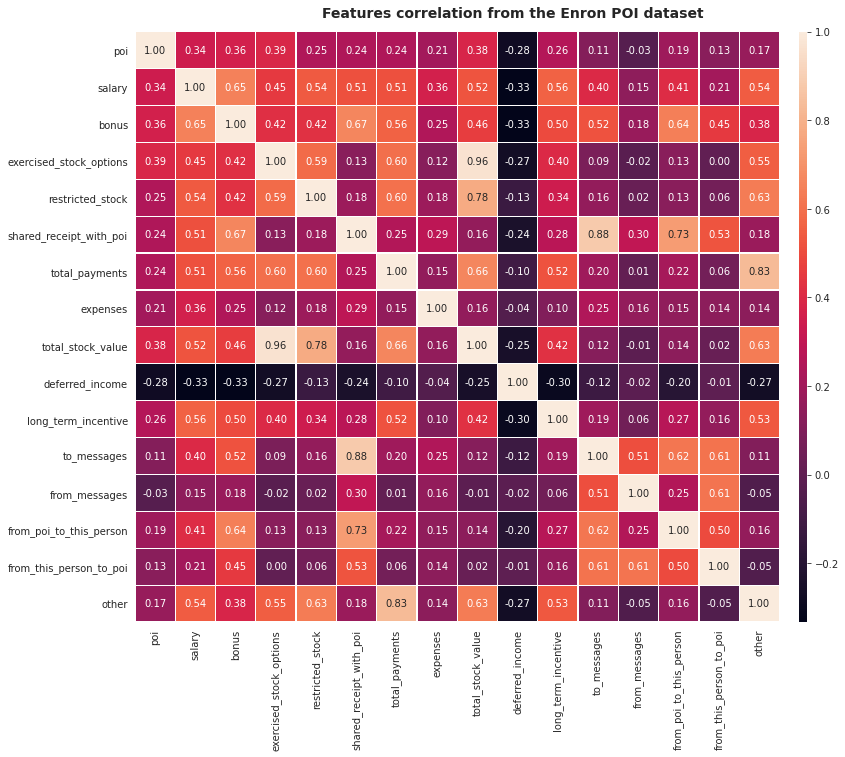

In [44]:
## Calculating the correlation among features by Pearson method
correlationDataframe = dataset[allFeatures].corr()

# Drawing a heatmap with the numeric values in each cell
fig1, ax = plt.subplots(figsize=(14,10))
fig1.subplots_adjust(top=.945)
plt.suptitle('Features correlation from the Enron POI dataset', fontsize=14, fontweight='bold')

cbar_kws = {'orientation':"vertical", 'pad':0.025, 'aspect':70}
sns.heatmap(correlationDataframe, annot=True, fmt='.2f', linewidths=.3, ax=ax, cbar_kws=cbar_kws);

<a id='sec3.2'></a>
### 3.2 Applying PCA on correlated features to generate a new one
Since the financial features are highly correlated, as seen above, we will now apply PCA to generate an only one new feature from them. 

In [45]:
from sklearn.decomposition import PCA

In [46]:
## Listing the financial features
financialFeatures

['salary',
 'bonus',
 'exercised_stock_options',
 'restricted_stock',
 'shared_receipt_with_poi',
 'total_payments',
 'expenses',
 'total_stock_value',
 'deferred_income',
 'long_term_incentive']

In [47]:
## Defining only one resulting component:
pca = PCA(n_components=1)
pca.fit(dataset[financialFeatures])

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [48]:
pcaComponents = pca.fit_transform(dataset[financialFeatures])

In [49]:
dataset['financial'] = pcaComponents

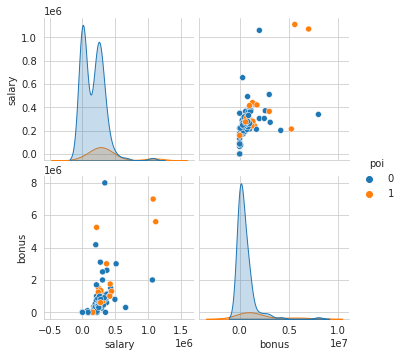

In [50]:
sns.pairplot(dataset,hue='poi',vars=['salary','bonus'], diag_kind='kde');

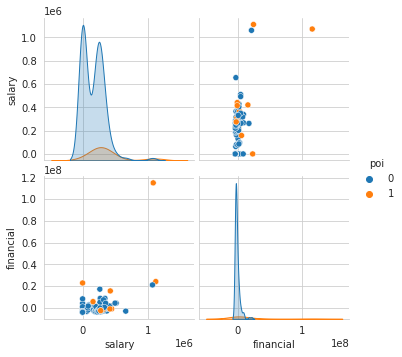

In [51]:
sns.pairplot(dataset,hue='poi',vars=['salary','financial'], diag_kind='kde');

<a id='sec3.3'></a>
### 3.3 Univariate feature selection

In [52]:
## Adding up the new 'financial' feature to the 'allFeatures' list:
allFeatures.append('financial')
financialFeatures.append('financial')

In [53]:
allFeatures

['poi',
 'salary',
 'bonus',
 'exercised_stock_options',
 'restricted_stock',
 'shared_receipt_with_poi',
 'total_payments',
 'expenses',
 'total_stock_value',
 'deferred_income',
 'long_term_incentive',
 'to_messages',
 'from_messages',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'other',
 'financial']

The code below is based on the example available in http://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py, in which an univariate feature selection is applied. 

In [54]:
from sklearn.feature_selection import SelectPercentile, f_classif

selectorDataset = dataset[financialFeatures]
selectorLabel = dataset['poi']

# #############################################################################
# Univariate feature selection with F-test for feature scoring
# We use the default selection function: the 5% most significant features
selector = SelectPercentile(f_classif, percentile=5)
selector.fit(selectorDataset, selectorLabel)

SelectPercentile(percentile=5,
                 score_func=<function f_classif at 0x7fbecea564d0>)

<BarContainer object of 11 artists>

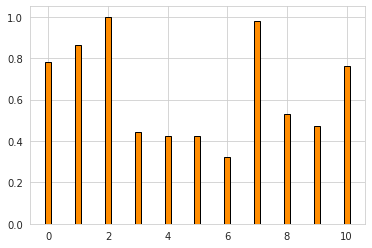

In [55]:
## Plotting the features selection: 
X_indices = np.arange(selectorDataset.shape[-1])
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.bar(X_indices, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange',
        edgecolor='black')

In [56]:
len(scores)

11

In [57]:
## Printing out the selected financial features: 
selectedFeatures = ['poi']  #'poi' must be the first one due to the evaluation methods defined by Udacity.
for ix, pval in enumerate(scores):
    print(financialFeatures[ix],': ',pval)
    if (pval >= 0.45):
        selectedFeatures.append(financialFeatures[ix])

salary :  0.7818686344960929
bonus :  0.8657013901313363
exercised_stock_options :  1.0
restricted_stock :  0.4447590111988349
shared_receipt_with_poi :  0.4228079784855426
total_payments :  0.42525219924626906
expenses :  0.32408364888457886
total_stock_value :  0.9794654890133486
deferred_income :  0.5288269433859027
long_term_incentive :  0.472735821399702
financial :  0.759729734365803


In [58]:
selectedFeatures

['poi',
 'salary',
 'bonus',
 'exercised_stock_options',
 'total_stock_value',
 'deferred_income',
 'long_term_incentive',
 'financial']

<a id='sec3.4'></a>
### 3.4. Alternative feature selection
Since the PCA applied to the financial features creates a new variable ('financial') which contains the most important components of the others, one alternative is to append it to the behavioral features selected before, in what we call *strategicFeatures*. In the next sections we will evaluate the performance of applying machine learning in this two classes of features.

In [59]:
strategicFeatures = ['poi'] + behavioralFeatures + ['financial']

In [60]:
strategicFeatures

['poi',
 'to_messages',
 'from_messages',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'other',
 'financial']

<a id='sec3.5'></a>
### 3.5. Feature scaling
Besides some of the machine learning algorithms chosen for this analysis (Naive Bayes and Adaboost) are invariant to feature scaling (Ref: https://stats.stackexchange.com/questions/244507/what-algorithms-need-feature-scaling-beside-from-svm), since we are also interested in using SVM it is important to apply feature scaling in our dataset. Furthermore, the "strategicFeatures" mixes two types of data, the financial data from PCA and the behavioral data from the number of emails sent.

In [61]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(dataset[allFeatures])
dataset[allFeatures] = scaler.transform(dataset[allFeatures])

<a id='sec4'></a>
## 4. Machine Learning

In this section we select some classification algorithms to apply on the features we extracted from our dataset. After applying each of the selected machine learning algorithms -- naive Bayes; Adaboost with decision trees; and SVM -- it is important to evaluate its classification results. Considering we have an unbalanced dataset, i.e. the number of samples for each class are distinct, we cannot use *accuracy* for measuring its performance. In this case we choose *precision* and *recall* for performance measurements. 

In [62]:
## Converting back the pandas Dataframe to the dictionary structure, in order to use the Udacity evaluating code.
my_dataset = dataset.to_dict(orient='index')
features_list = selectedFeatures
#features_list = strategicFeatures


def featureFormat( dictionary, features, remove_NaN=True, remove_all_zeroes=True, remove_any_zeroes=False, sort_keys = False):
    """ convert dictionary to numpy array of features
        remove_NaN = True will convert "NaN" string to 0.0
        remove_all_zeroes = True will omit any data points for which
            all the features you seek are 0.0
        remove_any_zeroes = True will omit any data points for which
            any of the features you seek are 0.0
        sort_keys = True sorts keys by alphabetical order. Setting the value as
            a string opens the corresponding pickle file with a preset key
            order (this is used for Python 3 compatibility, and sort_keys
            should be left as False for the course mini-projects).
        NOTE: first feature is assumed to be 'poi' and is not checked for
            removal for zero or missing values.
    """
    return_list = []
    # Key order - first branch is for Python 3 compatibility on mini-projects,
    # second branch is for compatibility on final project.
    if isinstance(sort_keys, str):
        import pickle
        keys = pickle.load(open(sort_keys, "rb"))
    elif sort_keys:
        keys = sorted(dictionary.keys())
    else:
        keys = dictionary.keys()

    for key in keys:
        tmp_list = []
        for feature in features:
            try:
                dictionary[key][feature]
            except KeyError:
                print("error: key ", feature, " not present")
                return
            value = dictionary[key][feature]
            if value=="NaN" and remove_NaN:
                value = 0
            tmp_list.append( float(value) )

        # Logic for deciding whether or not to add the data point.
        append = True
        # exclude 'poi' class as criteria.
        if features[0] == 'poi':
            test_list = tmp_list[1:]
        else:
            test_list = tmp_list
        ### if all features are zero and you want to remove
        ### data points that are all zero, do that here
        if remove_all_zeroes:
            append = False
            for item in test_list:
                if item != 0 and item != "NaN":
                    append = True
                    break
        ### if any features for a given data point are zero
        ### and you want to remove data points with any zeroes,
        ### handle that here
        if remove_any_zeroes:
            if 0 in test_list or "NaN" in test_list:
                append = False
        ### Append the data point if flagged for addition.
        if append:
            return_list.append( np.array(tmp_list) )
    return np.array(return_list)

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)

def targetFeatureSplit( data ):
    """ given a numpy array like the one returned from featureFormat, separate out the first feature and put it into its own list
    (this should be the quantity you want to predict) return targets and features as separate lists (sklearn can generally 
    handle both lists and numpy arrays as input formats when training/predicting) """
    target = []
    features = []
    for item in data:
        target.append( item[0] )
        features.append( item[1:] )
    return target, features


labels, features = targetFeatureSplit(data)

In [63]:
## Splitting the data:
# Example starting point. Try investigating other evaluation techniques!
# from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

In [64]:
## Defining an evaluation metric based on (http://scikit-learn.org/stable/modules/model_evaluation.html)
from sklearn.metrics import classification_report
def evaluateClassif(clf):
    classes=['Non-POI','POI']  ## Defining the classes labels
    predTrain = clf.predict(features_train)
    print('################### Training data ##################')
    print(classification_report(labels_train, predTrain, target_names=classes))
    
    predTest = clf.predict(features_test)
    print('################### Testing data ###################')
    print(classification_report(labels_test, predTest, target_names=classes))
    
    return

In [65]:
## Importing GridSearch algorithm for parameter selection:
from sklearn.model_selection import GridSearchCV

<a id='sec4.1'></a>
### 4.1 Naive Bayes classifier

In [66]:
#%%## Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html
# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb_parameters = {}

In [67]:
clf_nb = GridSearchCV(nb, nb_parameters)
clf_nb.fit(features_train, labels_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=GaussianNB(priors=None, var_smoothing=1e-09),
             iid='deprecated', n_jobs=None, param_grid={},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [68]:
evaluateClassif(clf_nb)

################### Training data ##################
              precision    recall  f1-score   support

     Non-POI       0.90      0.93      0.92        87
         POI       0.45      0.36      0.40        14

    accuracy                           0.85       101
   macro avg       0.68      0.64      0.66       101
weighted avg       0.84      0.85      0.84       101

################### Testing data ###################
              precision    recall  f1-score   support

     Non-POI       0.93      0.95      0.94        40
         POI       0.33      0.25      0.29         4

    accuracy                           0.89        44
   macro avg       0.63      0.60      0.61        44
weighted avg       0.87      0.89      0.88        44



<a id='sec4.2'></a>
### 4.2 AdaBoost classifier

In [69]:
### Adaboost Classifier
### http://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_twoclass.html#sphx-glr-auto-examples-ensemble-plot-adaboost-twoclass-py
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [70]:
## Defining the Adaboost parameters for GridSearch:
abc_parameters = {"learning_rate" : [0.5, 1., 2., 5., 10., 100.],
                 "n_estimators": [10,50,100,200,500,900,2000],
                 "algorithm": ['SAMME','SAMME.R']}

dtc = DecisionTreeClassifier(random_state = 42, max_features = "auto", max_depth = None)
abc = AdaBoostClassifier(base_estimator=dtc)

# run grid search
clf_adaboost = GridSearchCV(abc, param_grid=abc_parameters)

In [71]:
clf_adaboost.fit(features_train, labels_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features='auto',
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf

In [72]:
evaluateClassif(clf_adaboost)

################### Training data ##################
              precision    recall  f1-score   support

     Non-POI       1.00      1.00      1.00        87
         POI       1.00      1.00      1.00        14

    accuracy                           1.00       101
   macro avg       1.00      1.00      1.00       101
weighted avg       1.00      1.00      1.00       101

################### Testing data ###################
              precision    recall  f1-score   support

     Non-POI       0.91      0.97      0.94        40
         POI       0.00      0.00      0.00         4

    accuracy                           0.89        44
   macro avg       0.45      0.49      0.47        44
weighted avg       0.82      0.89      0.85        44



<a id='sec4.3'></a>
### 4.3. SVM classifier

In [73]:
from sklearn import svm
svm_parameters = {'kernel':['linear','rbf','poly','sigmoid'], 
                  'C':[0.5,1.,5.,10.,50.,100.,1000.], 'gamma':['scale']}
svr = svm.SVC()

In [74]:
clf_svc = GridSearchCV(svr, svm_parameters);

In [75]:
clf_svc.fit(features_train, labels_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 1000.0],
                         'gamma': ['scale'],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [76]:
evaluateClassif(clf_svc)

################### Training data ##################
              precision    recall  f1-score   support

     Non-POI       0.88      0.99      0.93        87
         POI       0.67      0.14      0.24        14

    accuracy                           0.87       101
   macro avg       0.77      0.57      0.58       101
weighted avg       0.85      0.87      0.83       101

################### Testing data ###################
              precision    recall  f1-score   support

     Non-POI       0.93      0.97      0.95        40
         POI       0.50      0.25      0.33         4

    accuracy                           0.91        44
   macro avg       0.71      0.61      0.64        44
weighted avg       0.89      0.91      0.90        44



<a id='sec4.4'></a>
### 4.4. Conclusions

Evaluating the output of the classifiers above, it's effort to choose **Naive Bayes Classifier**, since it had the best considered metrics (precision and recall) for POI in the testing data. It must be considered, though, that we could use more strategies to iterate the test and to certify this would be the best machine learning algorithm to be used. 